# Investigating the Traveling Salesman Problem with metaheuristics

* Andris Jansons
* Daniel Jones
* Author 3


[https://github.coventry.ac.uk/380CT-2021/Group-07](https://github.coventry.ac.uk/380CT-2021/Group-07)

# 1) Notation and definitions

Let $G$ be a [complete]( "graph is undirected, has no self-loops, and each node is connected to all the other vertices")  [weighted]( "the edges have a weight (a positive integer)") graph with $n$ vertices.

**Optimisation TSP**:
> Given $G$, find a cycle of minimal total cost.

This problem is **NP-Hard** because its decision version is **NP-complete** (Garey and Johnson, 1979, p. 211).

# 2) Testing methodology

In [1]:
def compare_algorithms(graph_type, algorithm, baseline_algorithm=lambda G: greedy_nearest_neighbour(G), \
                       n_range=range(2, 100, 3), repetitions=5):
    """
    Evaluate an algorithm against another algorithm.
    Comparison happens for a graph of graph_type with vertices in n_range.
    Each test is repeated repetitions times.
    """
    results = pd.DataFrame(columns=['n', 'time', 'quality'])

    i = 0
    for n in n_range:
        print(n, end='')
        for repetition in range(repetitions):
            print('.', end='')
            G = Graph(n, graph_type)

            # Solve with Baseline algorithm
            baseline_start_time = perf_counter()
            baseline_path, baseline_weight = baseline_algorithm(G)
            baseline_end_time = perf_counter()

            # Solve with the specific algorithm
            start_time = perf_counter()
            path, weight = algorithm(G)
            end_time = perf_counter()

            # Compare time as a percentage difference
            # A negative 100% indicates algorithm taking twice as much time as the baseline algorithm
            baseline_time = baseline_end_time - baseline_start_time
            time = end_time - start_time
            time_difference = (time - baseline_time) / baseline_time * 100 * -1
            # Compare quality as a percentage difference
            # A positive 100% indicate that tne algorithm can produce a result with
            # 2 times less weight than the baseline algorithm can produce for the same graph
            quality_difference = (weight - baseline_weight) / baseline_weight * 100 * -1
            
            # Collect data
            results.loc[i] = [n, time_difference, quality_difference]
            i += 1
    
    return results

def graph_results(results):
    """Display results from compare_algorithms function on graphs"""
    fig, (time, quality) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    
    sns.scatterplot(data=results, x='n', y='time', alpha=0.3, ax=time, color='#777')
    sns.lineplot(data=results, x='n', y='time', ci='sd', ax=time, color='red')
    time.set_title('Relative time change over number of cities');
    time.set_xlabel('Number of cities (count)')
    time.set_ylabel('Relative time change (%)')

    sns.scatterplot(data=results, x='n', y='quality', alpha=0.3, ax=quality, color='#777')
    sns.lineplot(data=results, x='n', y='quality', ci='sd', ax=quality, color='green')
    quality.set_title('Relative weight change over number of cities');
    quality.set_xlabel('Number of cities (count)')
    quality.set_ylabel('Relative weight change (%)')

```
.................................................................
.................................................................
...  You can add or improve this section and its subsections  ...
.................................................................
.................................................................
```

* **Greedy and meta-heuristics**:
    Average _time_ and _"quality"_ as $n$ increases.

Instances will be generated randomly as shown in the next subsection.

## 2.1) Random instances sampling strategy

Four types of TSP instances will be generated by creating an **adjacency matrices** $M$ as follows:
1. **Asymmetric**: The edge weights are independent and uniformly random in an interval $[1,\text{MAX_WEIGHT}]$, i.e the graph is assumed to be directed.
2. **Symmetric**: Like the asymmetric case but the graph is undirected, and the matrix is therefore symmetric: $M_{ij}=M_{ji}$.
3. **Euclidean**: Generate points using $(x,y)$ coordinates, then generate the adjacency matrix by calculating all the required distances. Recall that the distance between two points $(x_1,y_1)$ and $(x_2,y_2)$ is $\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$. The points are generated in the rectangle defined by the points $(0,0)$ and $(\text{MAX_Y},\text{MAX_Y})$.
4. **Graphs with obvious shortest cycle**: A graph where all the distances are 2 except for the edges on a predefined cycle, where the distance is 1. Such a graph would be useful for testing/debugging the "nearest neighbour greedy" search.

### Implementation of the instances generation

First start by importing relevant libraries.

In [2]:
from random import random, choice, choices, randint, shuffle, sample, uniform # random integers and random shuffling of a list
from itertools import permutations # iterate over all possible permutations of a list
from itertools import chain # concatenate range()'s'
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt, log, factorial  # square root, logarithm, and n!
from time import perf_counter # for measuring time. NB. 'perf_counter' is better/more accurate than 'time'
import networkx as nx # to draw sample graphs
import pandas as pd # to show the adjacency matrix in a nice format
import matplotlib.pyplot as plt # to plot graphs of time and quality vs n
import seaborn as sns # nice statistical plots -- see e.g. https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
import numpy as np
sns.set_style("white")

### Basics

Let the set of vertices be $\{0, 1, 2,\ldots, n-1\}$.

For simplicity, we will consider $0$ to be the start and end point of cycles.

In [3]:
class Graph:
    ''' Random graphs '''
    def __init__(self, n=0, type='asymmetric', MAX_WEIGHT=100, MAX_X=200, MAX_Y=200):
        self.n = n
        self.vertices = list(range(n)) # [0,1,...,n-1]
        self.type = type
        self.adj_matrix = [[oo for i in range(n)] for j in range(n)]
        # Generate a random adjacency matrix according to the required type
        if   type=='symmetric': self.__random_symmetric_graph(n,MAX_WEIGHT)
        elif type=='Euclidean': self.__random_euclidean_graph(n,MAX_X,MAX_Y)
        elif type=='easy':      self.__random_cycle_graph(n)
        else:                   self.__random_asymmetric_graph(n,MAX_WEIGHT) # assume 'asymmetric' otherwise
            
    def __getitem__(self, i):
        ''' Allow indexing to get the weights '''
        return self.adj_matrix[i]
                
    def __random_asymmetric_graph(self,n, MAX_WEIGHT):
        ''' Asymmetric adjacency matrix of size nxn '''
        for i in range(n):
            for j in range(n):
                if i==j: continue # no self-loops
                self.adj_matrix[i][j] = randint(1,MAX_WEIGHT)

    def __random_symmetric_graph(self,n,MAX_WEIGHT):
        ''' Symmetric adjacency matrix of size nxn '''
        for i in range(n):
            for j in range(i+1,n):
                w = randint(1,MAX_WEIGHT)
                self.adj_matrix[i][j] = w
                self.adj_matrix[j][i] = w

    def __random_cycle_graph(self,n):
        ''' Symmetric adjacency matrix of size nxn with one reandomly chosen cycle
        All the edge weights are 2 except for the cycle (weight=1) '''
        self.adj_matrix = [[2 for _ in range(n)] for _ in range(n)] # All weights=2
        # Select a random cycle which will have weight=1
        cycle = list(range(1,n)) # don't include 0 as we want to be at the start
        shuffle(cycle) # in-place random permutation
        cycle = [0]+cycle+[0] # cycle starting and ending at 0
        for a,b in zip(cycle, cycle[1:]): # set the cycle's weights to 1
            self.adj_matrix[a][b] = 1
            self.adj_matrix[b][a] = 1

    def __random_euclidean_graph(self,n,MAX_X,MAX_Y):
        ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
        # (1/2) Generate random (x,y) points
        points = set()
        while len(points)<n: # We may get duplicate (x,y) so we try until we get enough points
            x,y = randint(0,MAX_X), randint(0,MAX_Y)
            points.add((x,y))
        points = list(points) # Sets are not indexed, so convert into a list
        # (2/2) Now compute the adjacency matrix
        for i in range(n):
            p1 = points[i]
            for j in range(i+1,n):
                p2 = points[j]
                distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
                self.adj_matrix[i][j] = distance
                self.adj_matrix[j][i] = distance
        self.points=points

In [4]:
def cost(G, cycle):
    """ Calculate the cost of the given cycle [0,...,0] in G """
    return sum(G[a][b] for a, b in zip(cycle, cycle[1:]))

### Utility functions on the Graph

- **show(Graph)**: Displays the adjacency matrix of the graph.
- **draw(Graph, path?, weight_tags?)**: Draws the graph. If a path is specified, only draws the edges in the path. If weight_tags is set to True, displays the weights on the edges.

In [5]:
def show(G):
    ''' Show adjacency matrix. Useful for debugging.
    'type' is a string from: Euclidean, Cycle, ...
    The distances are round to 1 decimal point for clarity/simplicity
    '''
    print(f"{G.n}x{G.n} {G.type} graph:")
    if G.type=='Euclidean': print("Points:",G.points)
    r = pd.DataFrame({str(i): G[i] for i in range(G.n)})
    display(r)
    
def nx_graph(G, path=None):
    ''' Convert G into NetworkX format '''
    nxG = nx.Graph() if G.type!='asymmetric' else nx.DiGraph() # undirected/directed graph
    nxG.add_nodes_from(G.vertices) # Add the vertices
    # Now add the edges
    if path is None:
        # If no specific path is given - Add all edges
        for a in G.vertices:
            for b in G.vertices:
                if a==b: continue # no self-loops
                nxG.add_edge(a, b, weight=G[a][b])
    else:
        # If path is given - Add only edges specified in path
        for i in range(len(path) - 1):
            a = path[i]
            b = path[i + 1]
            nxG.add_edge(a, b, weight=G[a][b])
    if G.type=='Euclidean': # add (x,y) coordinates if available
        pos=dict(enumerate(G.points)) # vertex:(x,y) pairs
        nx.set_node_attributes(nxG, pos, 'coord')
    return nxG

def draw(G, path=None, weight_tags=False):
    ''' Draw the graph G using NetworkX '''
    nxG = nx_graph(G, path)
    weights_dictionary = nx.get_edge_attributes(nxG,'weight')
    edges,weights = zip(*weights_dictionary.items())
    pos = nx.circular_layout(nxG) if G.type!='Euclidean' else nx.get_node_attributes(nxG,'coord')
    nx.draw(nxG, pos, \
            with_labels=True, node_color='red', font_color='white', font_weight='bold', font_size=14,\
            edge_color=weights, width=1.5, connectionstyle="arc3,rad=0.1", edge_cmap=plt.cm.copper)
    # see https://matplotlib.org/stable/gallery/color/colormap_reference.html
    if weight_tags:
        nx.draw_networkx_edge_labels(nxG, pos, edge_labels=weights_dictionary)

## 3) Nearest Neigbour Greedy method

#### Idea

Start at city 0, move to the nearest city, then from there to the next nearest city, and so on, until all cities are visited. Finally, return back to the start city.

#### Pseudocode

1. $city \gets 0$
2. $visited\gets []$
3. **while** not all cities are visited **do**
4. $\quad$ $nearest\_city \gets \text{nearest city to $city$ that has not been visited yet}$
5. $\quad$ Append $city$ to $visited$ $\qquad\qquad\text{(i.e. mark $city$ as visited)}$
5. $\quad$ $city\gets nearest\_city$
6. **end while**
8. **return** $visited$

#### Running time analysis

The while-loop costs $O(n)$, and searching for the nearest city on line 4 costs $O(n)$ also, while the rest can be assumed to cost $O(1)$.
So the total cost of this greedy approach is therefore $O(n)\times O(n) = O(n^2)$.

#### Implementation

In [6]:
def greedy_nearest_neighbour(G):
    ''' Returns best found cycle and its cost '''
    unvisited = G.vertices.copy()
    visited = [] # solution to be built
    city = 0 # Start city
    while len(unvisited)>0:
        # Find nearest neighbour
        nearest_city = None
        shortest_distance = oo
        for neighbour in unvisited:
            if G[city][neighbour] < shortest_distance:
                shortest_distance = G[city][neighbour]
                nearest_city = neighbour
        # Update 'cycle' and 'cities' and G then 'city'
        visited.append(city)
        unvisited.remove(city)
        city = nearest_city
    # Add starting city to visited
    visited.append(visited[0])
    return visited, cost(G, visited)

# 4) Metaheuristics

```
............................................................
............................................................

Meta-heuristic 1
- Explanation/Idea/Skeleton
- High-levle pseudocode
- Big-O analysis of time (and space if deemed significant/useful)
- Implementation
- Experiments on time & quality (vs greedy) for graphs with up to 100's of vertices (Choose 1 or multiple graph topologies)

............................................................
............................................................

Ditto for Meta-heuristic 2

............................................................
............................................................

* You may have the experiments combined for both meta-heuristics in one place if you prefer. Either way is acceptable.
* Either way you should consider having the 2 meta-heuristics compared against each other (to be able to make a recommendation in the conclusion).

............................................................
............................................................

- Conclusion (Based on your theoretical analysis and experimental findings, give clear and precise practical recommendations on which methods to use given the size and/or structure of the graph.)

............................................................
............................................................

- List of references

............................................................
............................................................
```

## 4.1) Ant Colony Optimisation

### Idea
Ant Colony Optimisation algorithm is a biologically-inspired metaheuristic which searches solution space by emulating the way ant colonies search for food.

Ants are able to locate food and without any direct form of communication with the colony they can coordinate retrieving it. The communication between ants happens through the use of pheromone. Once food is found ants leave the pheromone on their path. As more pheromone builds up, more ants will follow the discovered path to the food.

The algorithm can be implemented in roughly the following steps:
1. Put ants on random cities.
1. For each ant, send the ant to all the other cities where they visit each city only once. The selection for which city to visit is initially random. After the first run, the next city selection becomes gradually more influenced by the amount of pheromone on a possible trail.
1. Once all ants have completed a tour of all cities, deposit pheromone on all paths. The amount of pheromone deposited by each ant is proportional to the length of the path traveled by the given ant.
1. Repeat the previous steps for multiple generations of ants.

<a id='city-selection'></a>
#### City selection
Ants select the next city to visit by making a random choice which is influenced by a probability. At each city, a probability distribution for next city selection from a list of possibilities is generated according to the following:

$\Large p_{ij} = \frac{(\tau_{ij}^{\alpha}) (\eta_{ij}^{\beta})}{\sum_{h \in E} (\tau_{ih}^{\alpha}) (\eta_{ih}^{\beta})}$

Where:
- **$i$** is the current city
- **$j$** is an unvisited city
- **$\tau_{ij}$** is the amount of pheromone on the trail between city $i$ and city $j$
- **$\eta_{ij}$** is the desirability of city $i$ relative to city $j$ (formulated as the inverse of the distance between $i$ and $j$)
- **$\alpha$** is the weighting factor for the pheromone
- **$\beta$** is the weighting factor for the desirability
- **$h$** is a city from the list of available (unvisited) cities
- **$E$** is a list of available (unvisited) cities

<a id='pheromone-update'></a>
#### Pheromone update
When all ants in a generation have completed their trips, the global pheromone trail is updated by each of them. The pheromone update from city $i$ to city $j$ is calculated with the following formula:

$\Large \tau_{ij} \gets \rho \tau_{ij} + \sum_{k}^{m} \Delta\tau_{ij}^{k}$

Where:
- **$i$** is the current city
- **$j$** is an unvisited city
- **$\tau_{ij}$** is the amount of pheromone on the trail between city $i$ and city $j$
- **$\rho$** pheromone residual coefficient (0-1), how fast the pheromone evaporates
- **$m$** is the number of ants
- **$\Delta\tau_{ij}^{k}$** is the amount of pheromone deposited by $k$th ant between city $i$ and city $j$

The pheromone deposited by $k$th ant between city $i$ and city $j$ is calculated by:

$\Large \Delta\tau_{ij}^{k} = \normalsize \begin{cases} Q/L_{k} \hspace{7mm} \text{if ant $k$ uses edge $ij$ in its tour} \\ 0 \hspace{15mm} \text{otherwise} \end{cases}$

Where:
- **$L_{k}$** is the cost of $k$th ant's path
- **$Q$** is the pheromone intensity

### Pseudocode

1. $n \gets \text{number of cities in graph}$
1. $pheromones \gets \text{$n \times n$ matrix with initial values as $\frac{1}{n^2}$}$
1. $best\_path \gets \emptyset$
1. **for each** generation **in** generations **do**
1. $\quad$ **for each** ant **in** ants **do**
1. $\quad\quad$ $path \gets \emptyset$
1. $\quad\quad$ **while** not all cities are visited **do**
1. $\quad\quad\quad$ $city \gets$ Choose the next city for $ant$ to visit according to [City selection](#city-selection)
1. $\quad\quad\quad$ Append $city$ to $path$
1. $\quad\quad$ **end while**
1. $\quad\quad$ **if** cost of $path$ $<$ cost of $best\_path$ **then**
1. $\quad\quad\quad$ $best\_path \gets path$
1. $\quad\quad$ **end if**
1. $\quad$ **end for**
1. $\quad$ Update $pheromones$ according to [Pheromone update](#pheromone-update)
1. **end for**
1. **return** $best\_path$

Originally introduced in paper:
[Ant system: optimization by a colony of cooperating agents](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=484436)


Implementation from paper:
[Travel Time Optimization Problem via Ant Colony and Genetic Evolution](https://static1.squarespace.com/static/59d9b2749f8dce3ebe4e676d/t/5dfaa5e3f9cc2c0a44498c7a/1576707559712/Final-Report.pdf)

Source code based on:
https://github.com/khanhnamle1994/trip-optimizer/blob/master/Bio-Inspired-Algorithms/aco.py

Related sources:
- [Paper: A Comparative Study of Three Metaheuristics Applied to the Traveling Salesman Problem](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4659314)
- [Blog: Python Ant Colony Optimisation Implementation](https://www.aransena.com/blog/2015/12/22/python-ant-colony-optimization)

#### Big O analysis

Time Complexity: $O(n^{2} \times m \times g)$

Where:
- **$n$** is the number of cities in the graph
- **$m$** is the ant count per generation
- **$g$** is the generation count

Assuming that the ant count $m$ and generation count $g$ doesn't change depending on the number of cities $n$ in the graph, we can assume that they will always run in constant time $O(1)$, which means that the Ant Colony Optimisation algorithm on the Travelling Salesman Problem runs in polynomial time and its time complexity is $O(n^2)$

### Implementation

In [ ]:
class AntColonyOptimisation:
    def __init__(self, ant_count=10, generations=100, alpha=1.0, beta=5.0, \
                 residual_coefficient=0.5, pheromone_intensity=10.0, verbose=False):
        self.ant_count = ant_count  # Ants per generation
        self.generations = generations  # Total ant generations
        self.alpha = alpha  # Relative importance of pheromone
        self.beta = beta  # Relative importance of desirability
        self.residual_coefficient = residual_coefficient  # Pheromone residual coefficient
        self.pheromone_intensity = pheromone_intensity  # Pheromone intensity
        self.verbose = verbose  # Whether should print intermediate decisions
    
    def solve(self, graph):
        best_cost = float('inf')
        best_solution = []
        
        # Pheromones is a N by N matrix with each initial pheromone set as 1 / (N**2),
        # where N is the number of cities in the graph
        pheromones = [[1 / (graph.n ** 2) for j in range(graph.n)] for i in range(graph.n)]
        
        for generation in range(self.generations):
            ants = [Ant(self, graph, pheromones) for i in range(self.ant_count)]
            for ant in ants:
                curr_costs = []
                for i in range(graph.n - 1):
                    # Move the ant between all cities
                    ant.select_next_city()
                # Finish the trip by moving the ant back to the starting city 
                ant.move_to_start_city()
                # Update costs
                curr_costs.append(ant.total_cost)
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = ant.path.copy()
                # Update ant pheromone delta
                ant.update_pheromone_delta()
            # Update pheromones to influence next generations path
            self.update_pheromones(pheromones, ants)
            # Debugging
            if self.verbose:
                print('Generation #{} best cost: {}, avg cost: {}, path: {}'.format(
                    generation + 1, best_cost, np.mean(curr_costs), best_solution))
        return best_solution, best_cost
            
    
    def update_pheromones(self, pheromones, ants):
        for i, row in enumerate(pheromones):
            for j, col in enumerate(row):
                pheromones[i][j] *= self.residual_coefficient
                for ant in ants:
                    pheromones[i][j] += ant.pheromone_delta[i][j]

                    
class Ant:
    def __init__(self, ant_colony, graph, pheromones):
        self.ant_colony = ant_colony
        self.graph = graph
        self.pheromones = pheromones
        self.total_cost = 0.0
        self.path = []  # List of the path taken by the ant
        self.pheromone_delta = []  # The local increase of pheromone
        # Cities which are available for next selection
        self.allowed_cities = graph.vertices.copy()
        # Create an N by N matrix with the desirability of each city
        # formulated as the inverse of the distance between cities
        self.desirability = [[0 if i == j else (1 / graph[i][j]) for j in graph.vertices] for i in graph.vertices]

        self.start = randint(0, graph.n - 1)  # Start from any node
        self._move_to_city(self.start)

    def select_next_city(self):
        """
        Select the next city influenced by the pheromone and its desirability
        and move the ant to that city
        """
        # Calculate probability denominator as sum of probability to all unvisited cities
        denominator = 0
        for i in self.allowed_cities:
            denominator += self._get_pheromone(i)  * self._get_desirability(i)

        # Probability for moving to a city in the next step
        probabilities = [0 for i in self.graph.vertices]
        for i in self.graph.vertices:
            if denominator == 0 or i not in self.allowed_cities:
                continue
            probabilities[i] = self._get_pheromone(i)  * self._get_desirability(i) / denominator

        # Select next city randomly based on the probabilities
        # Visited cities have a probability of 0, so they won't be chosen
        next_city = np.random.choice(self.graph.vertices, p=probabilities)

        self.total_cost += self.get_distance(next_city)
        self._move_to_city(next_city)

    def update_pheromone_delta(self):
        """Place pheromone on the path proportional to the total cost of the path"""
        self.pheromone_delta = [[0 for j in self.graph.vertices] for i in self.graph.vertices]
        for _ in range(1, len(self.path)):
            i = self.path[_ - 1]
            j = self.path[_]
            self.pheromone_delta[i][j] = self.ant_colony.pheromone_intensity / self.total_cost

    def get_distance(self, city):
        """Get the distance of moving to the next city"""
        return self.graph[self.current][city]
    
    def move_to_start_city(self):
        """Finish the ant's trip by moving back to the starting city"""
        self.total_cost += self.get_distance(self.start)
        self.path.append(self.start)
            
    def _get_pheromone(self, city):
        """Get the pheromone to the city from the current location with the relative imporance"""
        return self.pheromones[self.current][city] ** self.ant_colony.alpha

    def _get_desirability(self, city):
        """Get the desirability to the city from the current location with the relative importance"""
        return self.desirability[self.current][city] ** self.ant_colony.beta

    def _move_to_city(self, city):
        """Move from the current city to the new city and update lists"""
        self.current = city
        self.path.append(city)
        self.allowed_cities.remove(city)

### Experiments

#### Experiment 1: **A single Euclidean graph**
Given a single Euclidean graph, draw the solution found by Greedy Nearest Neighbour algorithm and the solution found by Ant Colony Optimisation algorithm and compare their costs. 

In [ ]:
G = Graph(10, 'Euclidean')
draw(G)

##### Greedy search

In [ ]:
path, weight = greedy_nearest_neighbour(G)
print('Final cost', weight)
print('Final path', path)
draw(G, path)

##### Ant Colony Optimisation

In [ ]:
aco = AntColonyOptimisation(generations=10, ant_count=10, verbose=True)
path, weight = aco.solve(G)
print('Final cost', weight)
print('Final path', path)
draw(G, path)

The path found by Ant Colony Optimisation is better (shorter) even for a simple graph with 10 cities. By exploring the intermediate results generation by generation, we can see that the initial generations had worse solutions compared to Greedy Nearest Neighbour algorithm, but over generations it improved and surpassed it.

#### Experiment 2: **Euclidean graphs**

Comparing time and quality for Ant Colony Optimisation algorithm over Greedy Nearest Neighbour algorithm on Euclidean graphs.
The comparison happens by increasing the city count in graph by 3 from 2 to 100 cities and repeating each test 5 times.

_Note: Higher values are better and values below 0 indicate performing worse._

In [ ]:
aco = AntColonyOptimisation(generations=10, ant_count=20, beta=10.0)
comparison_results = compare_algorithms('Euclidean', lambda G: aco.solve(G))
graph_results(comparison_results)

For Euclidean graphs the time needed to compute a solution using Ant Colony Optimisation is around 5000 times more for 40-100 cities than the time needed to compute a solution using Greedy Nearest Neighbour algorithm. However, a solution produced by Ant Colony Optimisation is constantly 10-15% better.

It's important to think about the applications. For instance, if the solution takes an hour to compute, but it makes a day-long trip 15% shorter, it could save 3.6 hours from the trip. 

#### Experiment 3: **Symmetric graphs**

Comparing time and quality for Ant Colony Optimisation algorithm over Greedy Nearest Neighbour algorithm on symmetric graphs.
The comparison happens by increasing the city count in graph by 3 from 2 to 100 cities and repeating each test 5 times.

_Note: Higher values are better and values below 0 indicate performing worse._

In [ ]:
aco = AntColonyOptimisation(generations=10, ant_count=20, beta=10.0)
comparison_results = compare_algorithms('symmetric', lambda G: aco.solve(G))
graph_results(comparison_results)

For symmetric graphs, the time needed to compute a solution using Ant Colony Optimisation over Greedy Nearest Neighbour algorithm is the same as for Euclidean graphs being 5000 times worse for 40-100 cities. However, the produced solution is 20-40% better which is a massive difference.

#### Experiment 4: **Asymmetric graphs**

Comparing time and quality for Ant Colony Optimisation algorithm over Greedy Nearest Neighbour algorithm on asymmetric graphs.
The comparison happens by increasing the city count in graph by 3 from 2 to 100 cities and repeating each test 5 times.

_Note: Higher values are better and values below 0 indicate performing worse._

In [ ]:
aco = AntColonyOptimisation(generations=10, ant_count=20, beta=10.0)
comparison_results = compare_algorithms('asymmetric', lambda G: aco.solve(G))
graph_results(comparison_results)

Asymmetric graphs have the same relative time change as for Euclidean and symmetric graphs being 5000 times worse for 40-100 cities. However, the generated solution by the Ant Colony Optimisation is 25-50% better than the solution by Greedy Nearest Neighbour algorithm.

#### Experiment 5: **Easy graphs**

Comparing time and quality for Ant Colony Optimisation algorithm over Greedy Nearest Neighbour algorithm on easy graphs.
The comparison happens by increasing the city count in graph by 3 from 2 to 100 cities and repeating each test 5 times.

_Note: Higher values are better and values below 0 indicate performing worse._

In [ ]:
aco = AntColonyOptimisation(generations=10, ant_count=20, beta=10.0)
comparison_results = compare_algorithms('easy', lambda G: aco.solve(G))
graph_results(comparison_results)

With easy graphs it's guaranteed that the Ant Colony Optimisation will find the best solution and so will Greedy Nearest Neighbour algorithm. Since the solutions are always the same, the downside of using Ant Colony Optimisation is that it takes 5000 times more time to compute a solution. 

## 4.2) Genetic Algorithm

## Definitions
* **Gene** - A node in the graph represented by a number e.g. [1]
* **Chromosome** - A route that satisfies the rules for the TSP e.g. [1, 2, 3]
* **Fitness** - The cost (i.e. the sum of the weights) of a given solution
* **Population** - A collection of chromosomes e.g. [[1, 2, 3], [3, 2, 1]]
* **Parents** - Two chromosomes that are selected to 'mate' i.e. go through the crossover process
* **Crossover** - The process of combining two parents in some way to create a child or offspring
* **Mating pool** - A Collection of possible parents selected according to fitness that are used to populate the next generation
* **Mutation** - Mutation involves taking a chromosome and changing it very slightly to introduce a wider variance to the solution space

### Idea
Genetic algorithms are a subset of evolutionary algorithms. With the biological process of natural selection in mind, genetic algorithms use biologically inspired operators such as chromosomes, mutation, crossover, and selection to help surface an optimal solution after a number of iterations.

**A high level overview of the approach used in this solution is summarised as follows**:
1. Create initial population of chromosomes (chromosomes in this case are random permutations of valid solutions
1. For each generation:
    1. Sort the population according to the fitness of a chromosome
    1. Immediately add the top two solutions to the next generation
    1. Iterate through the mating pool of chromosomes (in this case, the most fit half of the population)
    1. Select two parents based on fitness proportionate selection (aka roulette wheel selection)
    1. Apply ordered crossover to the two parents twice to create two child chromosomes
    1. Apply mutation operator to the two children
    1. Add the two children to the next generation and repeat
    

### Pseudocode
The pseudocode documented below describes how the combination of functions work in conjunction to define the Genetic Algorithm used in this approach.
1. $G \gets \text{list of graph vertices}$
1. $N \gets \text{amount of nodes in graph}$
1. $P \gets \text{size of population}$
1. $initial\_population \gets \text{[[random sample (G, N)] * P}]$
1. **for each** generation **in** generations **do**
1. $\quad\quad$ $population \gets [sorted($population by fitness$)]$
1. $\quad\quad$ $next\_generation \gets population[0:2]$
1. $\quad\quad$ **for each** $i$ in $len(population / 2) -1$ **do**
1. $\quad\quad\quad\quad parent\_a, parent\_b \gets \text{fitness proportionate selection(population)}$
1. $\quad\quad\quad\quad \text{offspring_a, offspring_b} \gets \text{crossover(parent_a, parent_b)}$
1. $\quad\quad\quad\quad \text{offspring_a} \gets \text{mutate(offspring_a)}$
1. $\quad\quad\quad\quad \text{offspring_b} \gets \text{mutate(offspring_b)}$
1. $\quad\quad\quad\quad \text{append offspring_a, offspring_b to next_generation}$
1. $\quad\quad$ **end for**
1. $\quad\quad$ $population \gets next\_generation$
1. **end for**
1. **return** $population$ where 0th element of sorted population is the best path

### Fitness proportionate selection
Fitness proportionate selection is used to select two parents for crossover and is defined as follows:
$\Large P_{c} = \frac{f_{c}}{\sum_{i=1}^{N} f_{c}}$

Where:
* $P_{c}$ is the probability of the chromosome being selected
* $f_{c}$ is the fitness of a chromosome $c$
* $N$ is the total size of the population


### Ordered Crossover (OX1)

To do

### Implementation

In [7]:
class GA:
    Chromosome = list[int]

    def __init__(self, P=100, verbose=False):
        self.P = P  # Size of the initial population
        self.verbose = verbose

    def __create_population(self, graph) -> list[Chromosome]:
        """Create initial randomly sampled population of chromosomes P times"""
        return [sample(graph.vertices.copy(), graph.n) for i in range(self.P)]

    def __fitness(self, graph, chromosome) -> float:
        """Evaluate fitness by taking chromosome and appending first element to the end.
        This is to check and return the fitness of the actual Hamlitonian cycle"""
        t = chromosome.copy()
        t.append(t[0])
        return cost(graph, t)

    def __select(self, graph, population) -> list[Chromosome, Chromosome]:
        """Fitness proportionate selection for two parents across population"""
        return choices(
            population=population,
            weights=[self.__fitness(graph, chromosome) for chromosome in population],
            k=2
        )
    

    def __crossover(self, parent_a, parent_b) -> Chromosome:
        """Apply ordered crossover to two parents to produce a new chromosome"""
        partial_a = []
        partial_b = []
        gene_a, gene_b = choice(parent_a), choice(parent_b)
        for i in range(min(gene_a, gene_b), max(gene_a, gene_b)):
            partial_a.append(parent_a[i])
        partial_b = [gene for gene in parent_b if gene not in partial_a]
        return partial_a + partial_b
    
    def __cycle_crossover(self, p1, p2) -> list[Chromosome, Chromosome]:
        """Experimental"""
        o1 = []
        o2 = []
        o1.append(p2[0])
        for i in range(len(p1)):
            o2.append(p2[p1.index(p2[p1.index(o1[i])])])
            if o2[-1] == p1[0]:
                if len(o1) == len(p1) and len(o2) == len(p2):
                    break
                else:
                    p2n = [i for i in p2 if i not in o2]
                    o1.append(p2n[0])
            else:
                if p2[p1.index(o2[i])] not in o1:
                    o1.append(p2[p1.index(o2[i])])
        return o1, o2

    def __mutate(self, chromosome, mutation_rate=0.1) -> Chromosome:
        """Simple two point probability mutation"""
        if random() < mutation_rate:
            pick = choice(chromosome)
            index = chromosome.index(pick)
            chromosome[index], chromosome[pick] = chromosome[pick], chromosome[index]
        return chromosome

    def ga_solve(self, graph, generations=500):
        """Combine functions to evolve population and iteratively find best solution"""
        population = self.__create_population(graph)
        for generation in range(generations):
            population = sorted(
                population,
                key=lambda chromosome: self.__fitness(graph, chromosome),
            )
            next_generation = population[0:self.P//2]
            if self.verbose:
                if not generation % 10:
                    print(f"Generation: {generation}")
                    print(f"Best solution: {next_generation[0]}")
                    print(f"Fitness: {self.__fitness(graph, next_generation[0])}")
            for i in range(len(next_generation)):
                parent_a, parent_b = self.__select(graph, next_generation)
                if random() < 0.8:
                    offspring_a = self.__crossover(parent_a, parent_b)
                    offspring_a = self.__mutate(offspring_a)
                    next_generation.append(offspring_a)
                else:
                    parent_a = self.__mutate(parent_a)
                    next_generation.append(parent_a)
            population = next_generation
        best_solution = sorted(population, key=lambda chromosome: self.__fitness(graph, chromosome))[0]
        best_cost = self.__fitness(graph, best_solution)
        best_solution.append(best_solution[0])
        return best_solution, best_cost


### Experiments

#### Experiment 1: **A single Euclidean graph**
Given a single Euclidean graph, draw the solution found by Greedy Nearest Neighbour algorithm and the solution found by the Genetic Algorithm and compare their costs. 

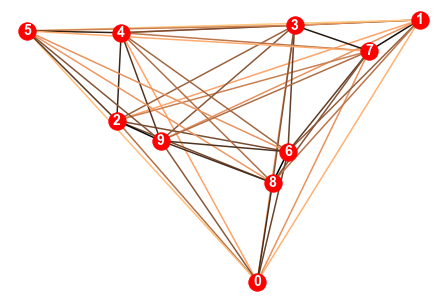

In [9]:
G = Graph(10, 'Euclidean')
draw(G)

**Greedy Search**

Final solution: [0, 8, 6, 9, 2, 4, 5, 3, 7, 1, 0]
Final cost: 593.4443616402245


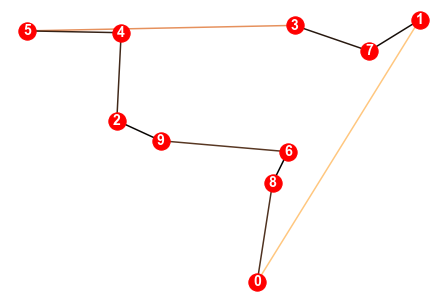

In [10]:
path, weight = greedy_nearest_neighbour(G)
print(f"Final solution: {path}")
print(f"Final cost: {weight}")
draw(G, path)

**Genetic Algorithm**

Final solution: [9, 2, 5, 4, 3, 1, 7, 6, 8, 0, 9]
Final cost: 522.3170539809133


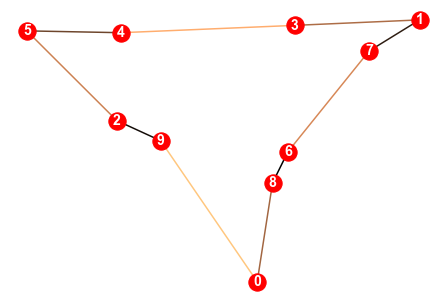

In [11]:
ga = GA(P=20, verbose=False)
path, weight = ga.ga_solve(G, generations=100)
print(f"Final solution: {path}")
print(f"Final cost: {weight}")
draw(G, path)

Even with a very low population, the Genetic Algorithm implementation consistently outperforms Greedy Search. We can see that the initial solution from generation 0 is worse than the final solution of Greedy Search but improves iteratively, reaching a better solution after just a few generations.

The results can of course be further improved by increasing the population size, though since the city count is initialised to just 10, the local optima are more quickly reached, leaving less or no room for improvement.

Final solution: [0, 9, 2, 5, 4, 3, 1, 7, 6, 8, 0]
Final cost: 522.3170539809132


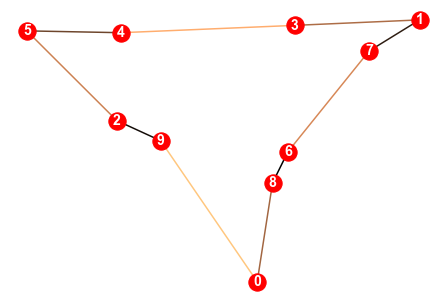

In [13]:
ga = GA(P=100)
path, weight = ga.ga_solve(G)
print(f"Final solution: {path}")
print(f"Final cost: {weight}")
draw(G, path)

#### Experiment 2: **Euclidean Graphs**

In this experiment we compare time and quality for the Genetic Algorithm against the Greedy Nearest Neighbour algorithm on Euclidean graphs. The comparison is made by incrementing the city count in the graph by 3, starting at 2 cities and going up to 100, repeating each test 5 times.

Note: Higher values are better and values below 0 indicate performing worse.

In [ ]:
ga = GA(P=20)  # Use default population of 100
comparison_results = compare_algorithms('Euclidean', lambda G: ga.ga_solve(G))
graph_results(comparison_results)

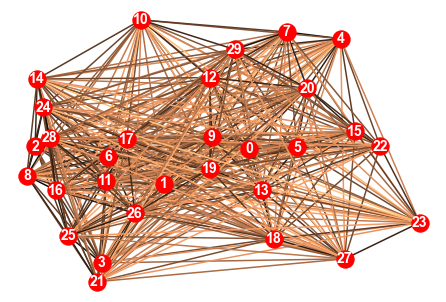

In [14]:
G = Graph(30, 'Euclidean')
draw(G)

Final solution: [0, 9, 19, 1, 26, 11, 6, 17, 28, 2, 8, 16, 25, 3, 21, 18, 13, 5, 15, 22, 20, 4, 7, 29, 12, 10, 14, 24, 27, 23, 0]
Final cost: 1171.6035103736003


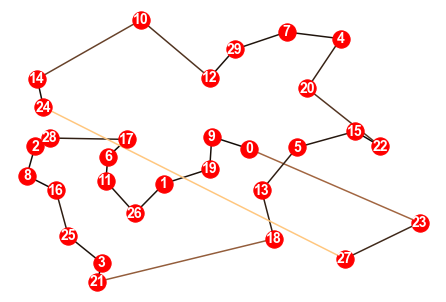

In [15]:
path, weight = greedy_nearest_neighbour(G)
print(f"Final solution: {path}")
print(f"Final cost: {weight}")
draw(G, path)

[25, 11, 16, 2, 28, 24, 14, 8, 6, 17, 9, 20, 4, 7, 10, 12, 29, 0, 5, 22, 15, 23, 27, 18, 13, 19, 1, 26, 3, 21, 25] 1121.1360471678747


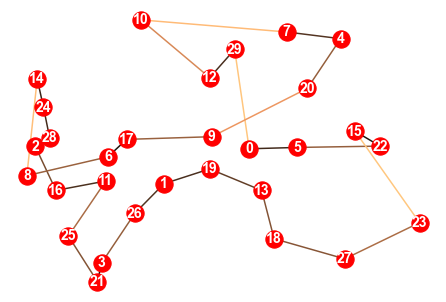

In [17]:
ga = GA(P=100, verbose=False)
path, weight = ga.ga_solve(G)
print(path, weight)
draw(G, path)